In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import itertools
import random as random
import shutil

colors_ls = (list(mcolors.TABLEAU_COLORS)[:120])
colors_ls_cyc = itertools.cycle(list(mcolors.TABLEAU_COLORS)[:120])
markers_ls = ['o','s','v', '+', 'o', '*']
markers = itertools.cycle(markers_ls)

from scipy.special import psi
from scipy.special import polygamma
from scipy.special import erf, erfinv
from scipy.optimize import curve_fit

%matplotlib inline
mpl.style.use('classic')
mpl.style.use(['seaborn-whitegrid'])
from matplotlib.ticker import ScalarFormatter, NullFormatter
mpl.rcParams['figure.dpi'] = 400
mpl.rcParams.update({'font.size': 16})

current_dir = os.getcwd() 
kPSep = os.sep

import struct
FLOAT_SIZE = 8

In [78]:
Lx = 20
Ly = 1
Ns = Lx * Ly
d = 1
bc = 1

Jdd = -1.0

cos_theta_af = np.array([1 if i % 2 == 0 else -1 for i in range(Lx)])
cos_theta_f = np.ones(Lx)

en_ferro = Jdd * np.sum(cos_theta_f[0:-1] * cos_theta_f[1:])
en_aferro = Jdd * np.sum(cos_theta_af[0:-1] * cos_theta_af[1:])

en_ferro, en_aferro

(-19.0, 19.0)

In [79]:
step = 0.1
J_max = 2.0
J_min = -2.0



J_s = np.arange(J_min, J_max+step, step).astype(np.float16)
J_d = np.arange()
J_s, len(J_s)

TypeError: arange() requires stop to be specified.

In [80]:
df = pd.read_csv(f"classical/type=square,_BC={bc},dim={d},Ns={Lx*Ly},Lx={Lx},Ly={Ly},Lz=1.dat", sep = '\t', names = ['J1','J2','E_ferro', 'E_aferro','E_ed','E_aed', 'idx']).dropna(axis = 1)
df['E_aferro'] -= en_aferro
df['E_ferro'] -= en_ferro
df['difference'] = df['E_aferro'] - df['E_ferro']
df[['E_ferro','E_aferro','E_ed','E_aed','difference']] /= Ns
print(df.dtypes)
df

J1            float64
J2            float64
E_ferro       float64
E_aferro      float64
E_ed          float64
E_aed         float64
difference    float64
dtype: object


,J1,J2,E_ferro,E_aferro,E_ed,E_aed,difference
0,1.6,-2.0,-1.177247,-2.871982,0.0,0.0,-1.694735
1,1.6,-1.9,-1.188245,-3.039470,0.0,0.0,-1.851225
2,1.6,-1.8,-1.112953,-2.973006,0.0,0.0,-1.860053
3,1.6,-1.7,-1.194347,-2.876834,0.0,0.0,-1.682487
4,1.6,-1.6,-1.156274,-2.278514,0.0,0.0,-1.122240
...,...,...,...,...,...,...,...
815,1.2,1.6,-0.845745,-2.383544,0.0,0.0,-1.537799
816,1.2,1.7,-0.901382,-2.420917,0.0,0.0,-1.519535
817,1.2,1.8,-1.033880,-2.295380,0.0,0.0,-1.261500
818,1.2,1.9,-0.969843,-1.894918,0.0,0.0,-0.925075


In [81]:
#fig = plt.figure()
#ax = plt.axes(projection='3d')
x = np.array(df['J1']).flatten()
y = np.array(df['J2']).flatten()
z = np.array(df['difference']).flatten()
#ax.scatter3D(x,y,z)

In [82]:
tmp = df[['J1','J2','difference']].sort_values(['J2']).astype(np.float32)
print(tmp.dtypes)
tmp

J1            float32
J2            float32
difference    float32
dtype: object


,J1,J2,difference
0,1.6,-2.0,-1.694735
738,-0.8,-2.0,0.848850
82,-1.0,-2.0,1.146169
697,0.6,-2.0,-1.216363
123,0.4,-2.0,-0.662301
...,...,...,...
614,2.0,2.0,-1.897105
655,-1.2,2.0,1.661819
696,-1.6,2.0,0.750310
368,0.2,2.0,-0.437890


In [83]:
import seaborn as sns
#fig, ax = plt.subplots(figsize = (10,10))
df_pivoted = tmp.pivot(columns='J1', index='J2', values='difference')
#c = ax.imshow(df_pivoted, cmap='RdYlGn')

#ax.set_yticks(np.arange(0, len(df_pivoted.columns)))
#ax.set_xticks(np.arange(-2.0, 2.0, 0.2), [str(i) for i in np.arange(-2.0, 2.0, 0.2)])
#ax.tick_params(labelrotation=0)
#fig.colorbar(c, ax=ax)
#plt.show()
#df_pivoted

41 20 41
(41, 20)


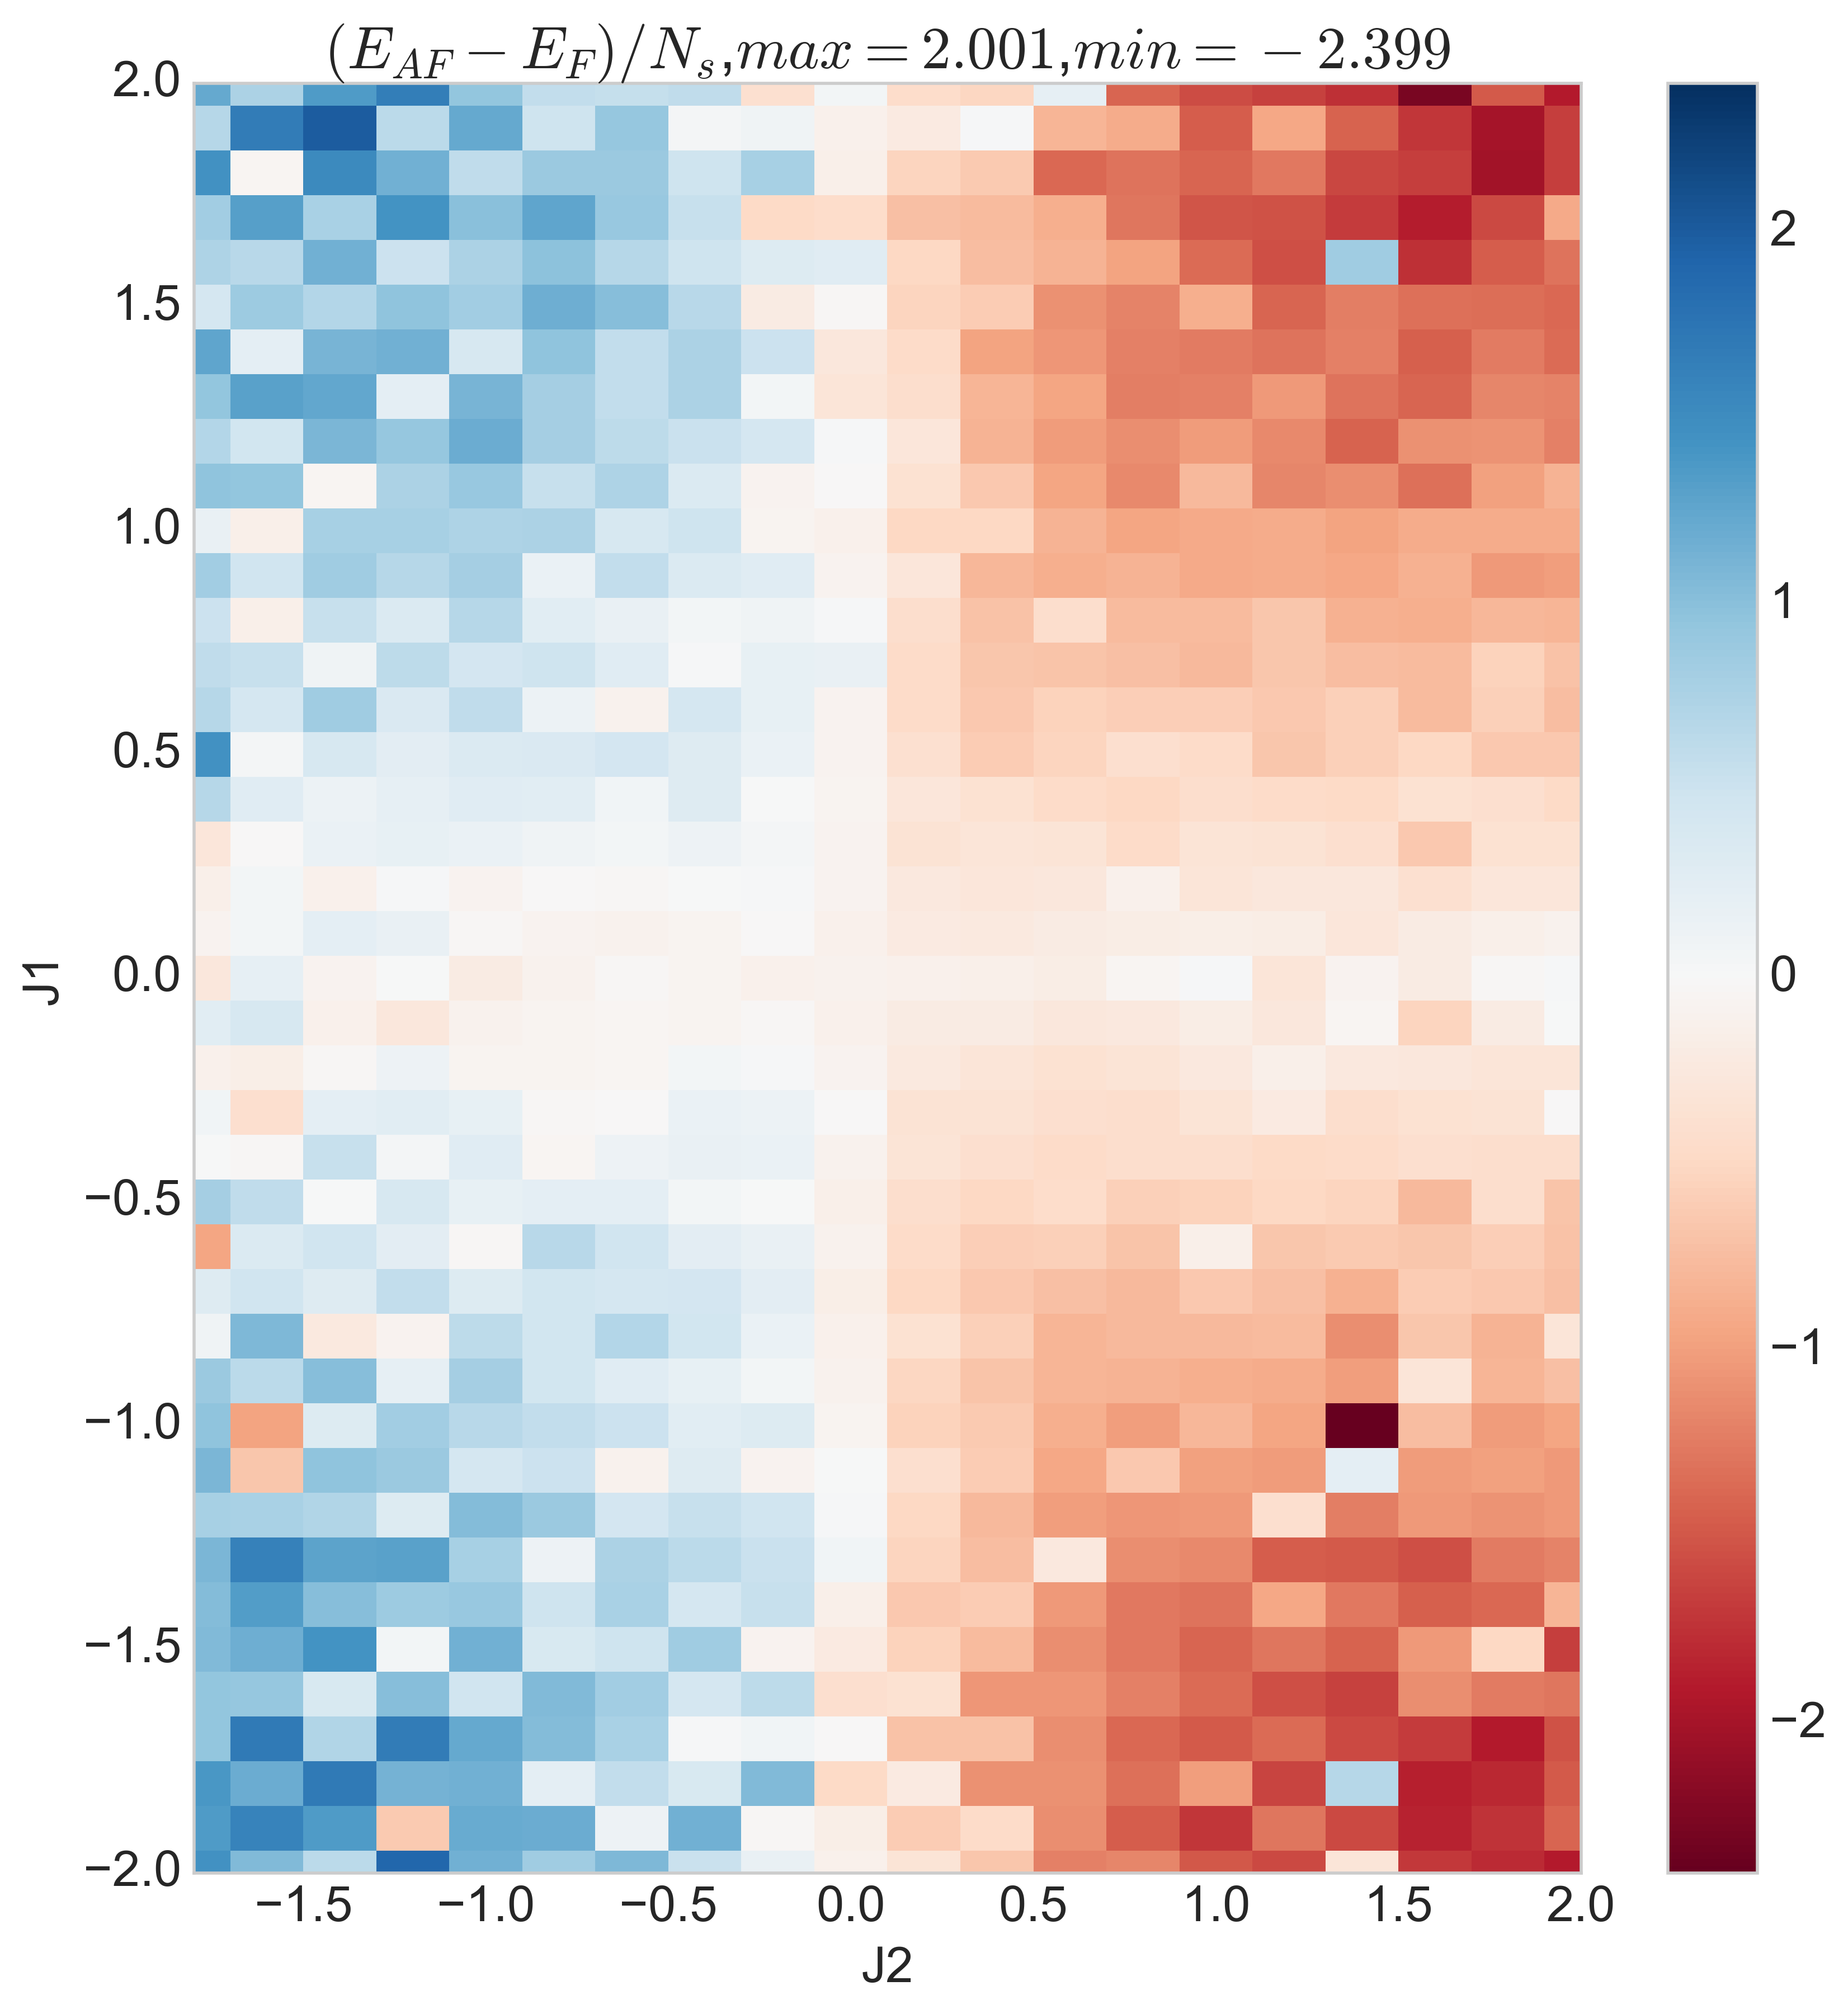

In [92]:
x, y = np.array(df_pivoted.index), np.array(df_pivoted.columns)
z = np.array(df_pivoted)
print(len(x), len(y),len(z))
print(z.shape)

iterator = 0

#z=z.reshape(len(x), len(y))
z_min, z_max = np.min(z), np.max(z)
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_xlim(np.min(y), np.max(y))
ax.set_ylim(np.min(x), np.max(x))
ax.set_xlabel('J2')
ax.set_ylabel('J1')
ax.set_title('$(E_{AF} - E_{F})/N_s$,'+f'$max={z_max:.3f}$,$min={z_min:.3f}$')
ax.tick_params(labelrotation=0)
c = ax.pcolormesh(y,x,z, cmap='RdBu', vmin=z_min, vmax=abs(z_min))
#c = ax.imshow(z)
#ax.set_xlim([np.min(x),np.max(x)])
#ax.set_ylim([np.min(y),np.max(y)])
fig.colorbar(c, ax=ax)
plt.show()